In [1]:
from PIL import Image
import torch
from torchvision import transforms
import numpy as np
import os
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
DEVICE = 'cuda:0'

In [2]:
from fm_goat import fm_goat_attack

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: e:\anaconda\envs\mts\lib\site-packages\lpips\weights\v0.1\alex.pth


In [3]:
import pyiqa
iqa_model = pyiqa.create_metric(
                'topiq_nr',
                as_loss=True,
                device=DEVICE
            )
iqa_name = 'TOPIQ'
iqa_range = 1.0

Loading pretrained model CFANet from C:\Users\1\.cache\torch\hub\checkpoints\cfanet_nr_koniq_res50-9a73138b.pth


In [4]:
from torchmetrics import StructuralSimilarityIndexMeasure
from lpips import LPIPS
from DISTS_pytorch import DISTS
pieapp = pyiqa.create_metric(
            'pieapp',
            as_loss=False,
            device=DEVICE
        )
lpips_model = LPIPS().to(DEVICE)
dists_model = DISTS().to(DEVICE)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)

Loading pretrained model PieAPP from C:\Users\1\.cache\torch\hub\checkpoints\PieAPPv0.1-0937b014.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: e:\anaconda\envs\mts\lib\site-packages\lpips\weights\v0.1\alex.pth


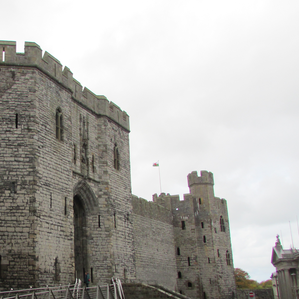

In [5]:
im_path = './img/example_1.png'
img = Image.open(im_path)
img_tensor = transforms.ToTensor()(img).to(DEVICE).unsqueeze(0) # convert to 1 x 3 x H x W
img

In [6]:
def image_to_numpy(x):
    return np.clip(x.permute(0,2,3,1).squeeze().detach().cpu().numpy() * 255, 0, 255).astype(np.uint8)

def calc_scores(clear, attacked):
    scores = {}
    with torch.no_grad():
        scores['clear'] = iqa_model(clear).item()
        scores['attacked'] = iqa_model(attacked).item()
        scores['SSIM'] = ssim(attacked, clear).item()
        scores['PieAPP'] = pieapp(attacked, clear).item()
        scores['DISTS'] = dists_model(attacked, clear).item()
        scores['LPIPS'] = lpips_model(attacked, clear).item()
    return scores

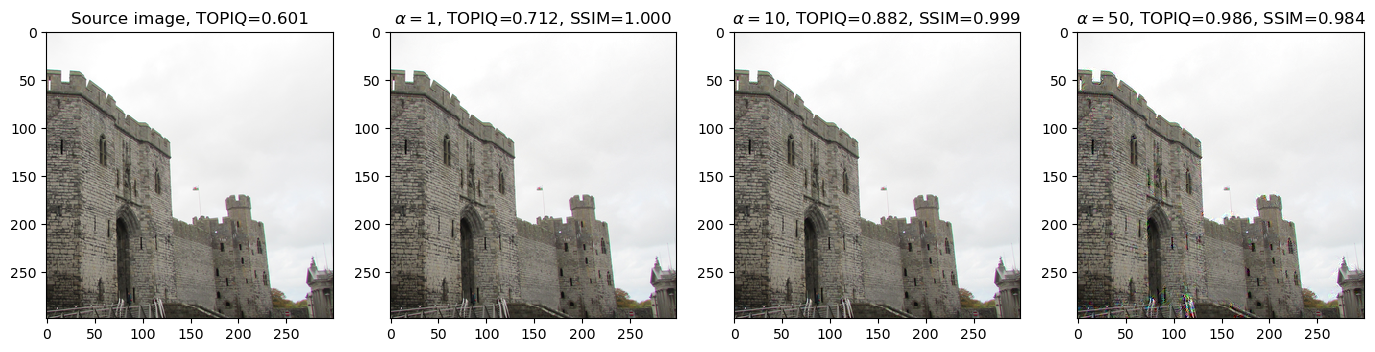

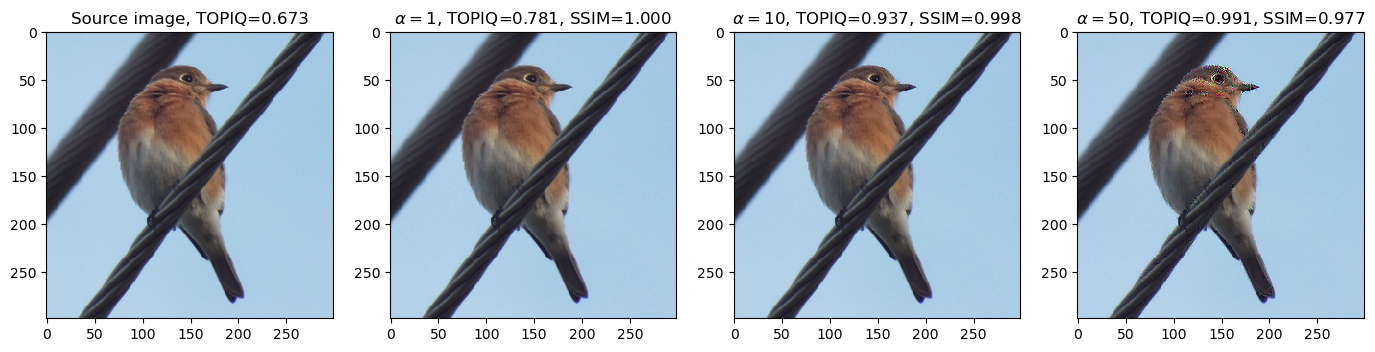

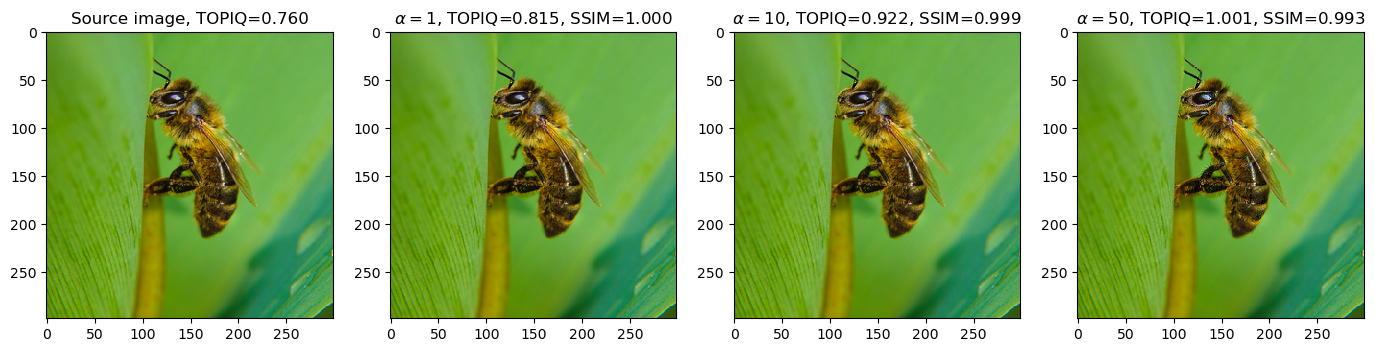

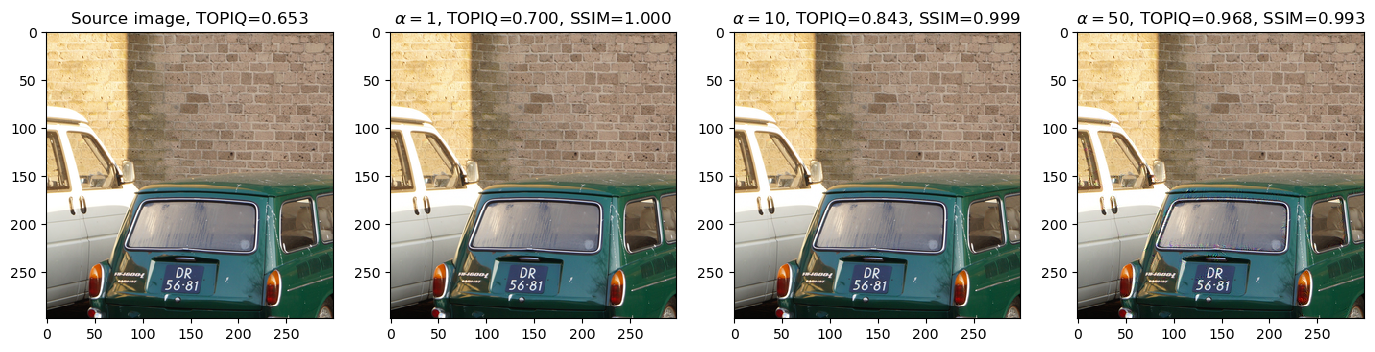

In [9]:
alphas = np.array([1,10,50])
im_dir_path = './img/'
img_names = [f'example_{i}.png' for i in range(1,5,1)]

for img_name in img_names:
    im_path = os.path.join(im_dir_path, img_name)
    img_tensor = transforms.ToTensor()(Image.open(im_path)).to(DEVICE).unsqueeze(0)

    attacked_img_tensors = [fm_goat_attack(img_tensor.clone(), iqa_model, alpha=x, metric_range=iqa_range, device=DEVICE) for x in alphas]
    with torch.no_grad():
        attacked_values = [iqa_model(x).item() for x in attacked_img_tensors]
        ssim_values = [ssim(x, img_tensor).item() for x in attacked_img_tensors]
        source_value = iqa_model(img_tensor).item()

    fig = plt.figure(figsize=(17,10))
    n_cols = 4
    n_rows = (len(alphas) + 1) // n_cols

    ax = plt.subplot(n_rows,n_cols, 1)
    plt.imshow(image_to_numpy(img_tensor), interpolation='none')
    ax.set_title(f"Source image, {iqa_name}={source_value:.3f}") 

    for i in range(len(alphas)):
        ax = plt.subplot(n_rows,n_cols, i + 2)
        plt.imshow(image_to_numpy(attacked_img_tensors[i]), interpolation='none')
        ax.set_title(f"$\\alpha={alphas[i]}$, {iqa_name}={attacked_values[i]:.3f}, SSIM={ssim_values[i]:.3f}") 